In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



model_type = "DENSE_baseline"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "standard"
use_noise_augmentor = False
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()



1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
2 3
Balancing due to disguised labels.
This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0
{'noise': 84799, 'earthquake': 84799, 'explosion': 82246}
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (2106, 0.2502)  |  explosion: (2023, 0.2404)  |  noise: (4287, 0.5094)  
Val ds:
earthquake: (46, 0.0352)  |  explosion: (629, 0.482)

In [3]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = False
start_from_scratch = False
use_reduced_lr = False
log_data = False

beta = 3

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModelRam(noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, 
                              start_from_scratch = start_from_scratch, beta = beta)
params = {
        "batch_size" : 128,
        "epochs" : 10,
        "learning_rate" : 0.01,
        "optimizer" : "sgd",
        "units" : 50,
        "dense_activation" : "relu",
        "output_layer_activation" : "sigmoid"
    }

model, _ = modelTrain.run(x_train, y_train, x_val, y_val, x_test, y_test, 16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, **params)

['20210423-184637']
[   {'model_type': 'DENSE_baseline'},
    {   'batch_size': 128,
        'dense_activation': 'relu',
        'epochs': 10,
        'learning_rate': 0.01,
        'optimizer': 'sgd',
        'output_layer_activation': 'sigmoid',
        'units': 50}]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
flatten (Flatten)            (None, 18000)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                900050    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 900,101
Trainable params: 900,101
Non-trainable params: 0
_________________________________________________

617 1 655 7


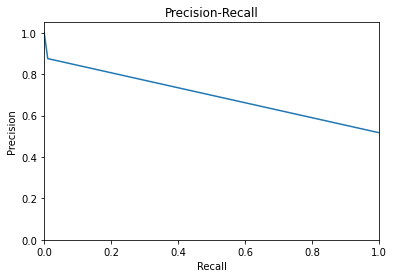

['noise', 'not_noise']
3N


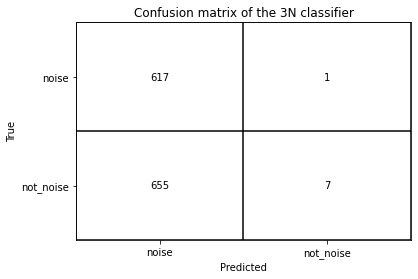

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[617,   1],
       [655,   7]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.49      1.00      0.65       618
   not_noise       0.88      0.01      0.02       662

    accuracy                           0.49      1280
   macro avg       0.68      0.50      0.34      1280
weighted avg       0.69      0.49      0.33      1280



In [6]:
conf, report, accuracy, precision, recall, fscore = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, 2, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [ ]:
precision, recall, fscore

In [ ]:
import matplotlib as plt
plt.plotconfusion(y_val, 2)